# Process Tail Sitter Frequency Response
This program is used to process tail sitter data to frequency response while cruising



In [24]:
#coding=utf-8 
%load_ext autoreload
%matplotlib inline
import sys
sys.path.insert(0, '../')
from AircraftIden.data_case.GeneralAircraftCase import GeneralAircraftCase, PX4AircraftCase
from AircraftIden import FreqIdenSIMO, TransferFunctionFit
import numpy as np
import matplotlib.pyplot as plt
import math

plt.rc('figure', figsize=(20.0, 10.0))

def show_logs(px4_case: PX4AircraftCase):
    print("LOW")
    needed_data = ['pitch_sp', 'ele', 'q', 'pitch']
    t_arr, data_list = px4_case.get_data_time_range_list(needed_data)
    print(t_arr)
    data_list[-1] = data_list[-1]/10
    plt.figure("Ele")
    plt.grid(which='both')
    plt.plot(t_arr, data_list[0], 'r.', label='ele')

    plt.figure("sourcedata")
    # print(t_arr)
    # print(data_list)
    for i in range(needed_data.__len__()):
        plt.plot(t_arr, data_list[i], label=needed_data[i])
    plt.legend()
    plt.show()


def split_logs(px4_case:PX4AircraftCase):
    needed_data = ["iden_start_time"]
    print("Will start split data with", needed_data)
    t_arr, data_list = px4_case.get_data_time_range_list(needed_data)
    iden_start_time = data_list[-1]
    data_splited = []
    is_in_a_test = False
    for i in range(1, t_arr.__len__()-1):
        if (iden_start_time[i] > iden_start_time[i+1] or (len(data_splited) > 0 and t_arr[i] - data_splited[-1]["start"] > 20)) \
                and is_in_a_test:
            data_splited[-1]["end"] = t_arr[i]
#             print("Data split {}th, {:5.2f}:{:5.2f}  len {:5.2f}".format(
#                 data_splited.__len__(), data_splited[-1]["start"], data_splited[-1]["end"],
#                 data_splited[-1]["end"] - data_splited[-1]["start"]
#             ))
            is_in_a_test = False

        # if (0 <= iden_start_time[i] < iden_start_time[i-1] and iden_start_time[i] < iden_start_time[i+1]):
        if (iden_start_time[i-1] <=0 and 0 < iden_start_time[i]):
            # Is a start
            is_in_a_test = True
            data_splited.append({"start": t_arr[i]})

    return data_splited


def join_data(data_splited, status):
    joined_data_status = {}
    assert data_splited.__len__() == status.__len__(), "Status Length must equal to data_split but {} {}".format(
        data_splited.__len__(), status.__len__())

    for i in range(data_splited.__len__()):
        status_test = status[i]
        if status_test == "-" or status_test == "wrong":
            continue
        if status_test in joined_data_status:
            #Join data
            joined_data_status[status_test].append((data_splited[i]["start"],data_splited[i]["end"]))
        else:
            joined_data_status[status_test] = [(data_splited[i]["start"], data_splited[i]["end"])]
    return joined_data_status

def split_and_join_data(px4_case:PX4AircraftCase,status):
    sp = split_logs(px4_case)
    return join_data(sp,status)

def get_concat_data(case, time_ranges, attrs, return_trimed = True):
    res = dict()
    count = 0
    sumup = 0
    for attr in attrs:
        attr_data = []
        for t_min, t_max in time_ranges:
            _, piece_data = self.get_data_time_range(
                [attr], t_min=t_min,
                t_max=t_max)
            # piece_data = remove_seq_average_and_drift(piece_data.copy())
            if return_trimed:
                piece_data = piece_data.copy() - np.average(piece_data)
            else:
                piece_data = piece_data.copy()
            # print("Do not remove drift")
            attr_data.append(piece_data)
        res[attr] = np.concatenate(attr_data)
        datalen = res[attrs[0]].__len__()
        totaltime = datalen / self.sample_rate
        tseq = np.linspace(0, totaltime, datalen)
    return totaltime, tseq, res
def plot_status_data(test_case, joined_data_status,needed_data):
    for key in joined_data_status:
        plt.figure("Data case: {}".format(key))
        plt.title("Data case: {}".format(key))
        total_time, t_data, datas = test_case.get_concat_data(joined_data_status[key], needed_data, False)
        for i in range(0, needed_data.__len__()):
            data = datas[needed_data[i]]
#             if needed_data[i] == "pitch":
#                 data = datas[needed_data[i]] * 180/3.1415

            trim_value = np.average(data)
            print(f"{key} Average {np.mean(trim_value * 180/3.1415)}")

            plt.plot(t_data, data, label=needed_data[i]+" Trim: {:4.2f}".format(trim_value))
            pass
        plt.legend()
        plt.grid(which='both')
    plt.show()

def process_status_data_pitchsp_to(test_case, joined_data_status,omg_min,omg_max,win_num=None):
    needed_data = ['pitch_sp', 'pitch']
    res = {}
    for key in joined_data_status:
        total_time, t_data, datas = test_case.get_concat_data(joined_data_status[key], needed_data)
        iden = FreqIdenSIMO(t_data, omg_min, omg_max, datas['pitch_sp'], datas["pitch"], uniform_input=True, win_num=None)#,assit_input=datas["thr"])
        res[key] = iden
    return res

def plot_idens_for_status(idens):
    for key in idens:
        iden = idens[key]
        plt.figure("psp_pitch")
        iden.plt_bode_plot(0, label=key, xmin=0.01, xmax=1)
        
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fpath = "../data/foam-tail-sitter/cruising/log_34_2018-4-10-16-16-04.ulg"
status = [
        "5m/s", "5m/s", "5m/s", "5m/s", "5m/s", "5m/s", "5m/s", "5m/s",
        "8m/s", "8m/s", "8m/s", "8m/s", "8m/s", "8m/s","8m/s", "8m/s",
        "10m/s", "10m/s", "10m/s", "10m/s", "10m/s", "10m/s","10m/s"
]
status_low = [
        "1m/s", "1m/s", "1m/s", "1m/s", "1m/s", "1m/s", "1m/s", "1m/s",
        "3m/s", "3m/s", "3m/s", "3m/s", "3m/s", "3m/s","3m/s", "3m/s",
        "-", "-", "-",
]

fpath_low = "../data/foam-tail-sitter/cruising/log_32_2018-4-10-15-53-08.ulg"

In [ ]:
#process_file(fpath,status)
print("Loading fast logs")
px4_case = PX4AircraftCase(fpath)
# show_logs(px4_case)


px4_case_low = PX4AircraftCase(fpath_low)
# show_logs(px4_case_low)
print("Loading low logs")

print("Finish loading logs")

In [5]:
%store px4_case_low
%store px4_case

In [4]:
%store -r

Will start split data with ['iden_start_time']
Will start split data with ['iden_start_time']
5m/s Average -27.88961504073222
5m/s Average -27.704327479928452
8m/s Average -46.76571624994866
8m/s Average -46.79786551730335
10m/s Average -53.78307114382614
10m/s Average -53.94018611998685


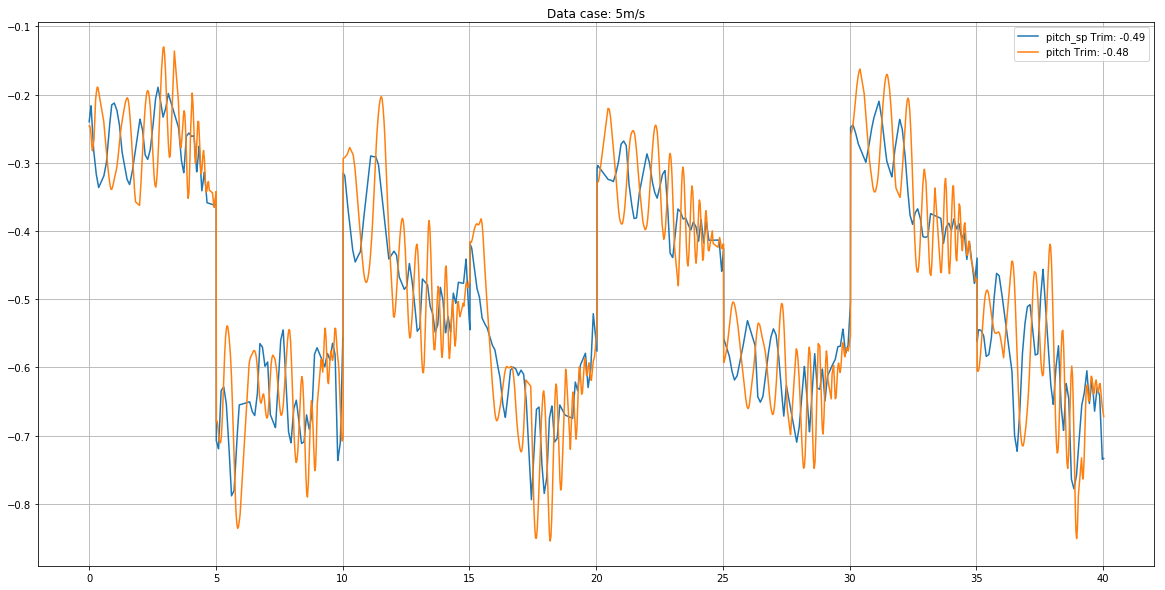

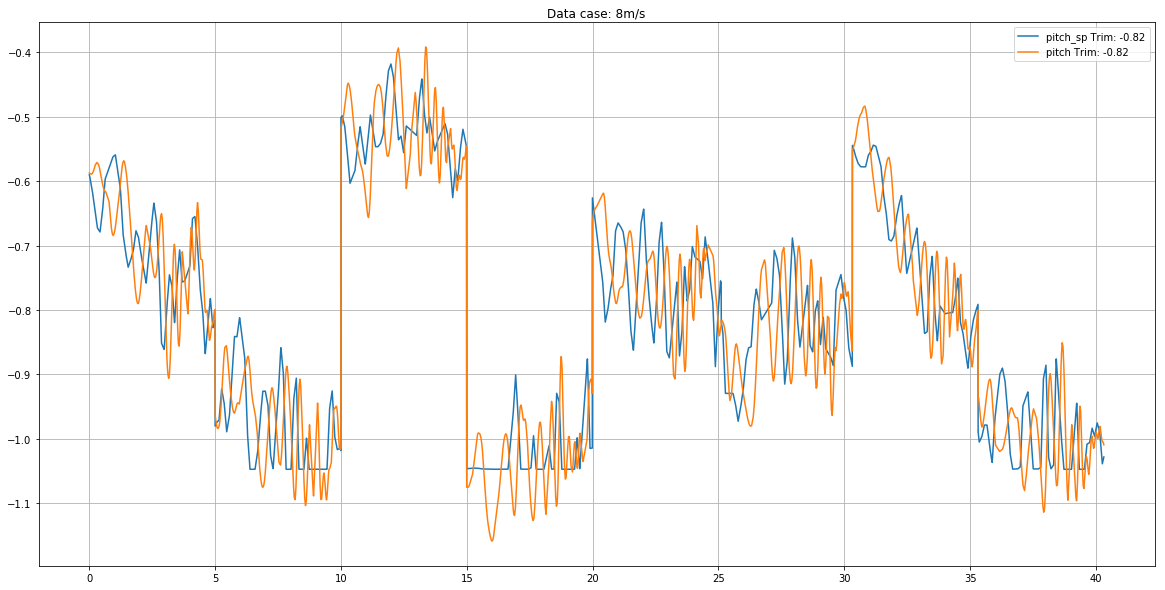

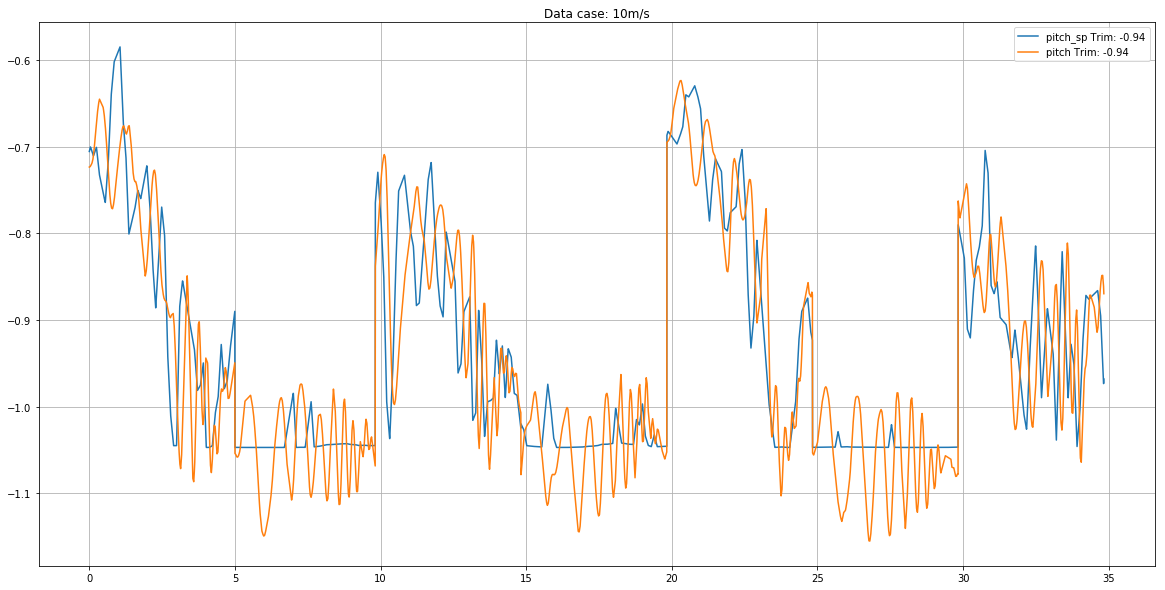

1m/s Average -6.308721653240469
1m/s Average -6.215484258458599
3m/s Average -14.97370905755114
3m/s Average -14.957122905536952


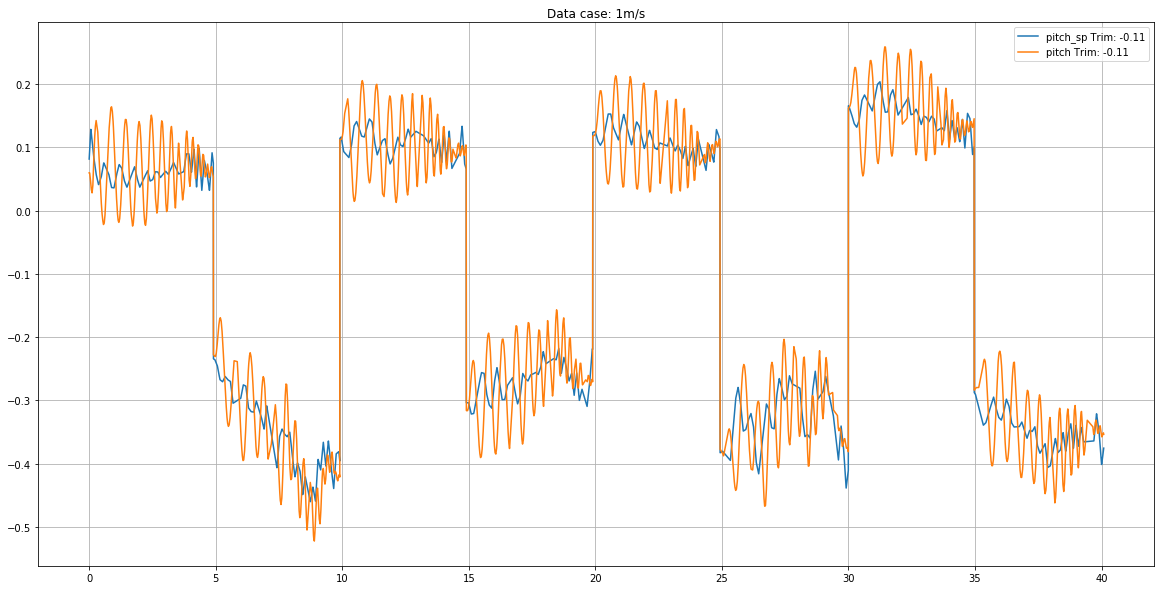

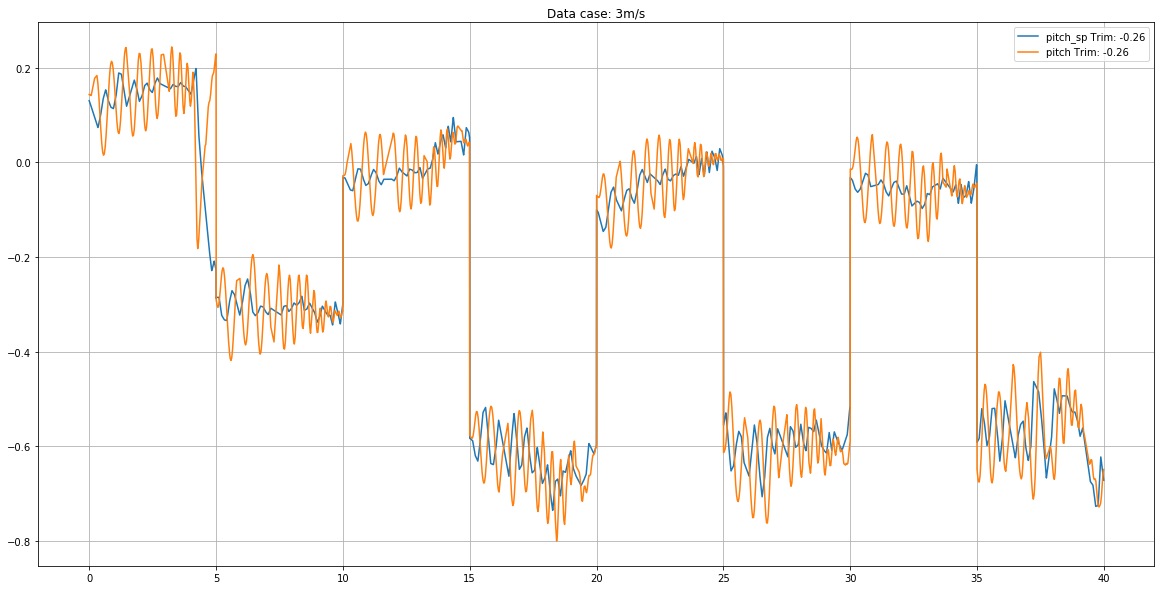

In [25]:

plt.rc('figure', figsize=(20.0, 10.0))
data_splited = split_logs(px4_case)
data_splited = join_data(data_splited, status)
data_splited_low = split_and_join_data(px4_case_low, status_low)
needed_data = ['pitch_sp', 'pitch']
plot_status_data(px4_case, data_splited,needed_data)
plot_status_data(px4_case_low, data_splited_low,needed_data)

In [7]:
print("Iden fast")
idens_psp = process_status_data_pitchsp_to(px4_case, data_splited, 0.01, 20)
print("Iden low")
idens_psp.update(process_status_data_pitchsp_to(px4_case_low, data_splited_low, 0.01, 20))

Iden fast
Sample rate is 200.0
Sample rate is 200.0
Setting-up composite win, sample rate 200.0 from omg 0.01 to 20
Composite using [5, 6, 8, 9, 11]


C:\Users\plane\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Sample rate is 200.0
Sample rate is 200.0
Setting-up composite win, sample rate 200.0 from omg 0.01 to 20
Composite using [5, 6, 8, 9, 11]
Sample rate is 200.0
Sample rate is 200.0
Setting-up composite win, sample rate 200.0 from omg 0.01 to 20
Composite using [5, 6, 7, 8, 10]
Iden low
Sample rate is 200.0
Sample rate is 200.0
Setting-up composite win, sample rate 200.0 from omg 0.01 to 20
Composite using [5, 6, 8, 9, 11]
Sample rate is 200.0
Sample rate is 200.0
Setting-up composite win, sample rate 200.0 from omg 0.01 to 20
Composite using [5, 6, 8, 9, 11]


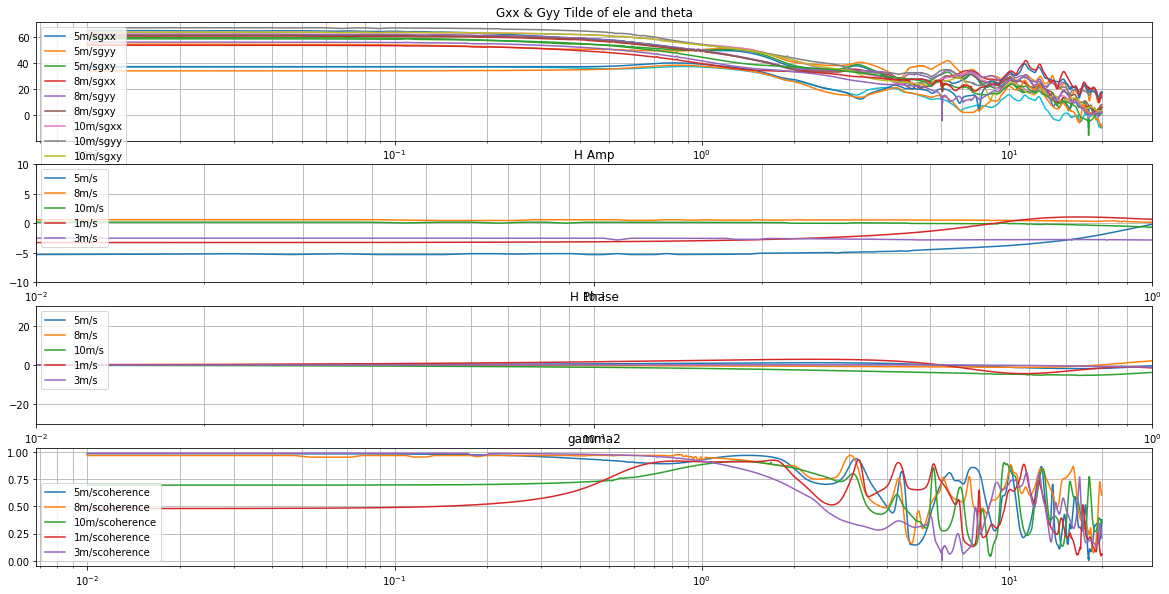

In [19]:
%autoreload
plt.rc('figure', figsize=(20.0, 10.0))
plot_idens_for_status(idens_psp)

In [8]:
import pickle
pkl_name = "../data/foam-tail-sitter/cruising/log_34_2018-4-10-freq-res-q.pkl"
f = open(pkl_name,"wb")
pickle.dump(idens_q, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
pkl_name = "../data/foam-tail-sitter/cruising/log_34_2018-4-10-freq-res-q.pkl"
finput = open(pkl_name, 'rb')
idens = pickle.load(finput)
plt.rc('figure', figsize=(20.0, 10.0))
plot_idens_for_status(idens_q)

In [4]:
%store px4_case
%store px4_case_low

Stored 'px4_case' (PX4AircraftCase)
Stored 'px4_case_low' (PX4AircraftCase)
